# Import necessary packages #

In [ ]:
!pip install tensorflow keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Essential
import matplotlib.pyplot as plt
import sys # to use getsizeof() function
import pickle
import numpy as np

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
X = np.load("/gdrive/My Drive/Sign language project/CombinedDatasetX.npy")

In [ ]:
y = np.load("/gdrive/My Drive/Sign language project/CombinedDatasetY.npy")

In [ ]:
# essential for google colab
actions_file= open("/gdrive/My Drive/Sign language project/actions_vids_no.pkl", "rb")
actions_vids_no = pickle.load(actions_file)
print(actions_vids_no)

{'hello': 130, 'no action': 90, 'thank you': 175, 'i love you': 140, 'again': 150, 'food': 150, 'me': 170, 'want': 130, 'forget': 140, 'friend': 140, 'please': 185}


In [ ]:
X.shape

(1600, 30, 1662)

In [ ]:
sys.getsizeof(X)

638208136

In [ ]:
y = to_categorical(y).astype(int)

In [ ]:
y.shape

(1600, 11)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.0625, random_state=42)

In [ ]:
y_test.shape

(100, 11)

In [ ]:
y_train.shape

(1500, 11)

In [ ]:
X_train.shape

(1500, 30, 1662)

In [ ]:
y_train

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0]])

# Build and train LSTM model #

In [ ]:
# Essential
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, BatchNormalization, LeakyReLU, GRU
from tensorflow.keras.callbacks import TensorBoard
import tensorflow as tf

In [ ]:
# Essential
model_LSTM_Batch_Norm = Sequential(
    [
        LSTM(64, return_sequences=False, activation='tanh', input_shape=(30, 1662), kernel_regularizer=tf.keras.regularizers.L2(l2=0.044), recurrent_regularizer=tf.keras.regularizers.L2(l2=0.014)),
        Dense(64, kernel_regularizer=tf.keras.regularizers.L2(l2=0.027)),
        BatchNormalization(),
        LeakyReLU(),
        Dense(32, kernel_regularizer=tf.keras.regularizers.L2(l2=0.027)),
        BatchNormalization(),
        LeakyReLU(),
        Dense(len(actions_vids_no.keys()), activation='softmax')
    ]
)

In [ ]:
# Essential
model_GRU_Batch_Norm = Sequential(
    [
        GRU(64, return_sequences=False, activation='tanh', input_shape=(30, 1662), kernel_regularizer=tf.keras.regularizers.L2(l2=0.044), recurrent_regularizer=tf.keras.regularizers.L2(l2=0.014)),
        Dense(64, kernel_regularizer=tf.keras.regularizers.L2(l2=0.027)),
        BatchNormalization(),
        LeakyReLU(),
        Dense(32, kernel_regularizer=tf.keras.regularizers.L2(l2=0.027)),
        BatchNormalization(),
        LeakyReLU(),
        Dense(len(actions_vids_no.keys()), activation='softmax')
    ]
)

In [ ]:
# Essential
# learning rate decay, used it because the loss was abruptly increasing while fitting the model, which
# meant that learning rate was note small enough
# PS. The problem was alleviated more after implementing batch normalization
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    initial_learning_rate= 0.002 ,
    decay_steps=8,
    decay_rate=0.5,
    staircase=False)

In [ ]:
# Essential
model_LSTM_Batch_Norm.compile(optimizer= tf.optimizers.Adam(learning_rate=lr_schedule), loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [ ]:

model_GRU_Batch_Norm.compile(optimizer= tf.optimizers.Adam(learning_rate=lr_schedule), loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [ ]:
model_LSTM_Batch_Norm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                442112    
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 batch_normalization_1 (Batc  (None, 32)               128       
 hNormalization)                                        

In [ ]:
model_GRU_Batch_Norm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 64)                331776    
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 batch_normalization_2 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 batch_normalization_3 (Batc  (None, 32)               128       
 hNormalization)                                      

In [ ]:
history_LSTM_Batch_Norm = model_LSTM_Batch_Norm.fit(X_train, y_train, epochs=150, batch_size = 64, validation_split=0.0667)

In [ ]:
with open('/gdrive/My Drive/Sign language project/history_LSTM', 'wb') as file_pi:
  pickle.dump(history_LSTM_Batch_Norm.history, file_pi)

### Model convergence improved dramatically after introducing batch normalization. Reached > 99% training accuracy within 100 epochs whereas previously around 600 epochs were required for model_LSTM (i.e. the model without batch normalization) ###

In [ ]:
history_GRU_Batch_Norm = model_GRU_Batch_Norm.fit(X_train, y_train, epochs=150, batch_size = 64, validation_split=0.0667)

In [ ]:
with open('/gdrive/My Drive/Sign language project/history_GRU', 'wb') as file_pi:
  pickle.dump(history_GRU_Batch_Norm.history, file_pi)

# Save Weights #

In [ ]:
model_GRU_Batch_Norm.save("/gdrive/My Drive/Sign language project/GRU_Batch_Norm.h5")

In [ ]:
model_LSTM_Batch_Norm.save("/gdrive/My Drive/Sign language project/LSTM_Batch_Norm.h5")

# Evaluation using Confusion Matrix #

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score, classification_report

In [ ]:
yhat = model_GRU_Batch_Norm.predict(X_test)

In [ ]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [ ]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[90,  0],
        [ 0, 10]],

       [[95,  1],
        [ 0,  4]],

       [[86,  0],
        [ 0, 14]],

       [[89,  0],
        [ 1, 10]],

       [[89,  0],
        [ 0, 11]],

       [[91,  0],
        [ 0,  9]],

       [[95,  0],
        [ 0,  5]],

       [[90,  0],
        [ 0, 10]],

       [[95,  0],
        [ 0,  5]],

       [[93,  0],
        [ 0,  7]],

       [[86,  0],
        [ 0, 14]]])

In [ ]:
accuracy_score(ytrue, yhat)

0.99

In [ ]:
print(classification_report(ytrue, yhat, target_names=actions_vids_no.keys()))

              precision    recall  f1-score   support

       hello       1.00      1.00      1.00        10
   no action       0.80      1.00      0.89         4
   thank you       1.00      1.00      1.00        14
  i love you       1.00      0.91      0.95        11
       again       1.00      1.00      1.00        11
        food       1.00      1.00      1.00         9
          me       1.00      1.00      1.00         5
        want       1.00      1.00      1.00        10
      forget       1.00      1.00      1.00         5
      friend       1.00      1.00      1.00         7
      please       1.00      1.00      1.00        14

    accuracy                           0.99       100
   macro avg       0.98      0.99      0.99       100
weighted avg       0.99      0.99      0.99       100



In [ ]:
yhat = model_LSTM_Batch_Norm.predict(X_test)

In [ ]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [ ]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[90,  0],
        [ 0, 10]],

       [[95,  1],
        [ 0,  4]],

       [[86,  0],
        [ 0, 14]],

       [[89,  0],
        [ 1, 10]],

       [[89,  0],
        [ 0, 11]],

       [[91,  0],
        [ 0,  9]],

       [[95,  0],
        [ 0,  5]],

       [[90,  0],
        [ 0, 10]],

       [[95,  0],
        [ 0,  5]],

       [[93,  0],
        [ 0,  7]],

       [[86,  0],
        [ 0, 14]]])

In [ ]:
accuracy_score(ytrue, yhat)

0.99

In [ ]:
print(classification_report(ytrue, yhat, target_names=actions_vids_no.keys()))

              precision    recall  f1-score   support

       hello       1.00      1.00      1.00        10
   no action       0.80      1.00      0.89         4
   thank you       1.00      1.00      1.00        14
  i love you       1.00      0.91      0.95        11
       again       1.00      1.00      1.00        11
        food       1.00      1.00      1.00         9
          me       1.00      1.00      1.00         5
        want       1.00      1.00      1.00        10
      forget       1.00      1.00      1.00         5
      friend       1.00      1.00      1.00         7
      please       1.00      1.00      1.00        14

    accuracy                           0.99       100
   macro avg       0.98      0.99      0.99       100
weighted avg       0.99      0.99      0.99       100



In [ ]:
history_GRU_file = open('/gdrive/My Drive/Sign language project/history_GRU', 'rb')
history_GRU = pickle.load(history_GRU_file)

In [ ]:
history_LSTM_file = open('/gdrive/My Drive/Sign language project/history_LSTM',"rb")
history_LSTM = pickle.load(history_LSTM_file)

In [ ]:
history_GRU.keys()

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])

In [ ]:
plt.rcParams.update({'font.size': 18})

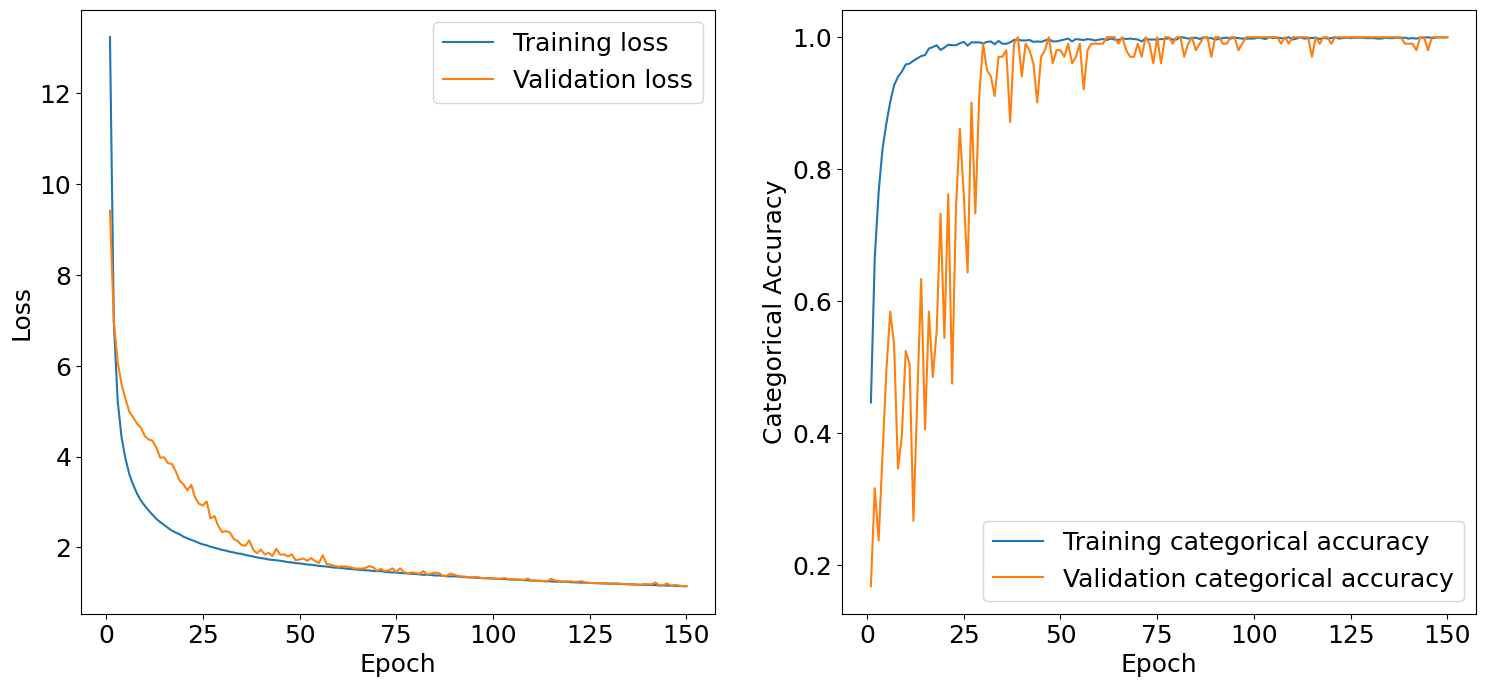

In [ ]:
x_points = np.arange(1,151)
y_points = np.array(history_GRU["loss"])
plt.figure(figsize=(18, 8), dpi=100)
plt.subplot(1, 2, 1)
plt.plot(x_points, y_points)
y_points2 = np.array(history_GRU["val_loss"])
plt.plot(x_points, y_points2)
plt.legend(["Training loss", "Validation loss"], loc ="upper right")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.subplot(1, 2, 2)
y_points = np.array(history_GRU["categorical_accuracy"])
plt.plot(x_points, y_points)
y_points2 = np.array(history_GRU["val_categorical_accuracy"])
plt.plot(x_points, y_points2)
plt.legend(["Training categorical accuracy", "Validation categorical accuracy"], loc ="lower right")
plt.xlabel("Epoch")
plt.ylabel("Categorical Accuracy")
plt.show()

# Row wise graphs #

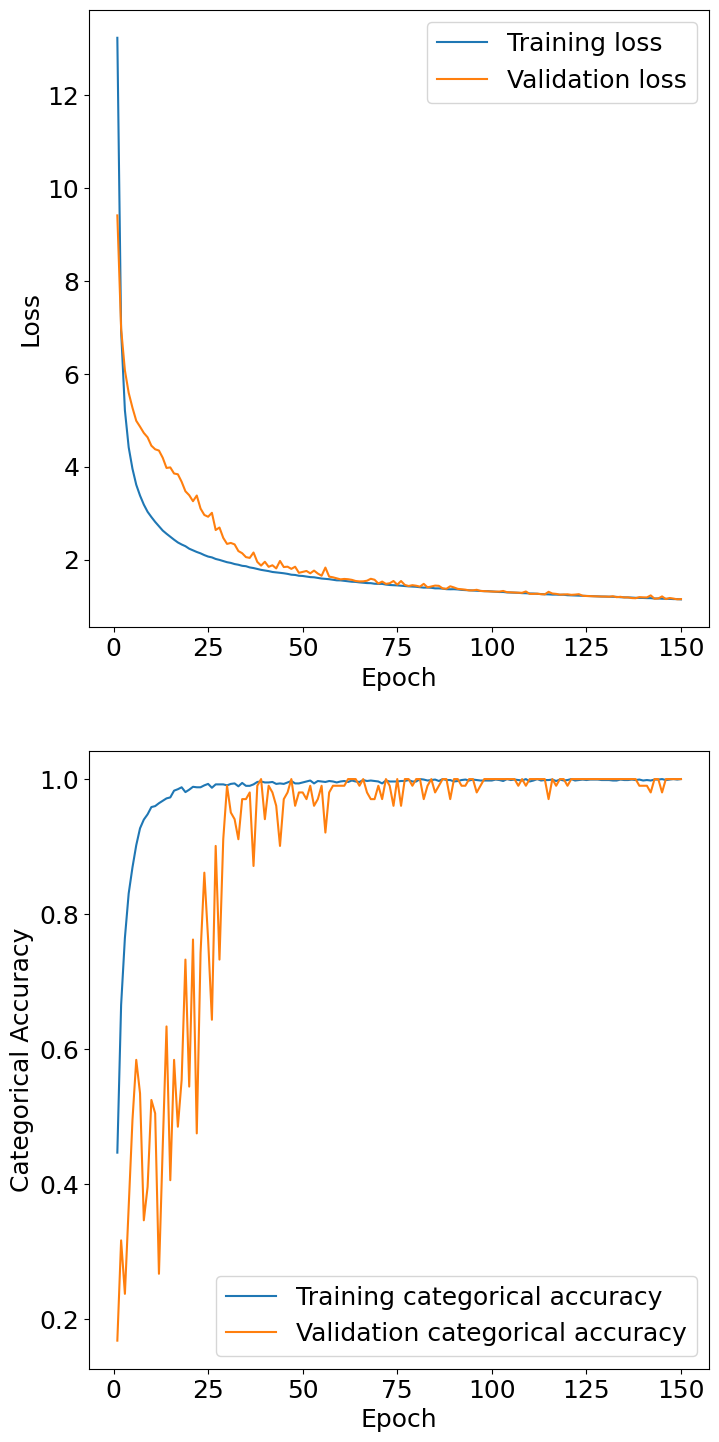

In [ ]:
x_points = np.arange(1,151)
y_points = np.array(history_GRU["loss"])
plt.figure(figsize=(8, 18), dpi=100)
plt.subplot(2, 1, 1)
plt.plot(x_points, y_points)
y_points2 = np.array(history_GRU["val_loss"])
plt.plot(x_points, y_points2)
plt.legend(["Training loss", "Validation loss"], loc ="upper right")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.subplot(2, 1, 2)
y_points = np.array(history_GRU["categorical_accuracy"])
plt.plot(x_points, y_points)
y_points2 = np.array(history_GRU["val_categorical_accuracy"])
plt.plot(x_points, y_points2)
plt.legend(["Training categorical accuracy", "Validation categorical accuracy"], loc ="lower right")
plt.xlabel("Epoch")
plt.ylabel("Categorical Accuracy")
plt.show()

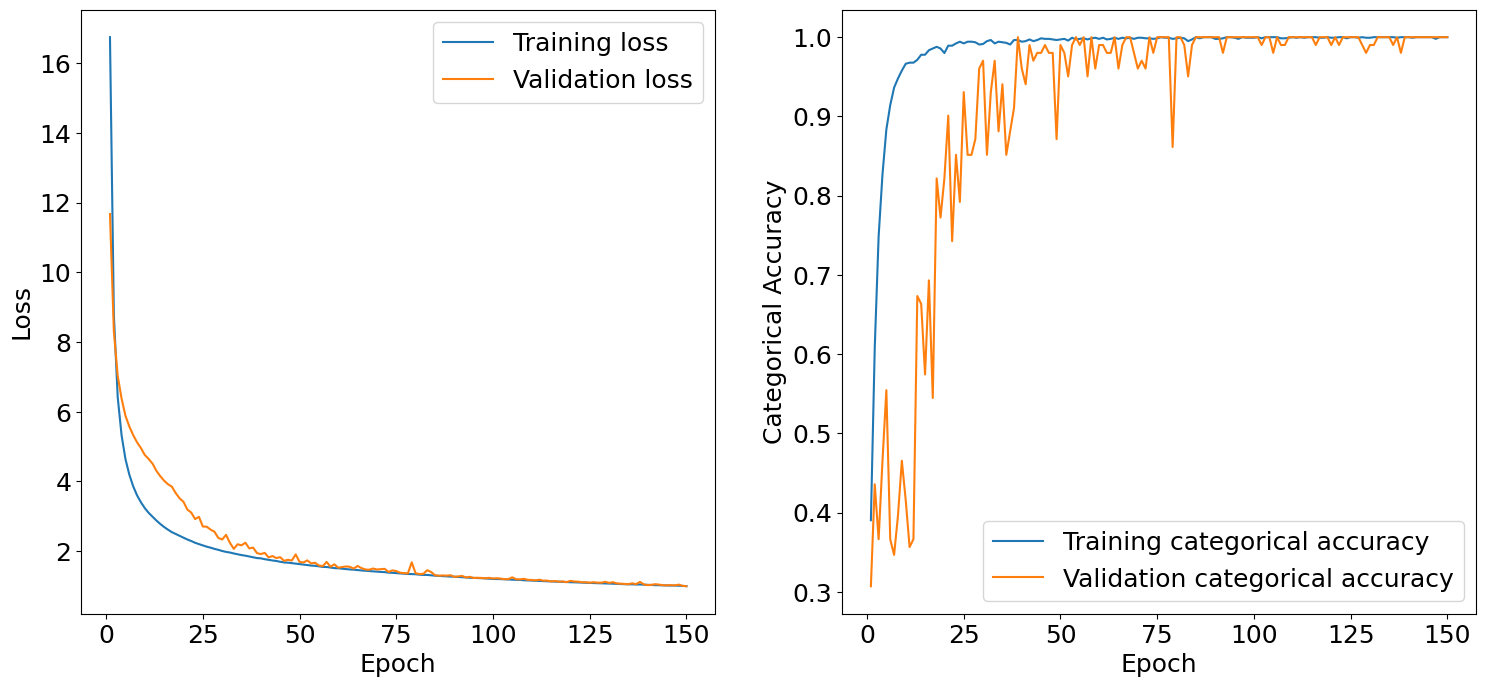

In [ ]:
x_points = np.arange(1,151)
y_points = np.array(history_LSTM["loss"])
plt.figux_points = np.arange(1,151)
y_points = np.array(history_LSTM["loss"])
plt.figure(figsize=(18, 8), dpi=100)
plt.subplot(1, 2, 1)
plt.plot(x_points, y_points)
y_points2 = np.array(history_LSTM["val_loss"])
plt.plot(x_points, y_points2)
plt.legend(["Training loss", "Validation loss"], loc ="upper right")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.subplot(1, 2, 2)
y_points = np.array(history_LSTM["categorical_accuracy"])
plt.plot(x_points, y_points)
y_points2 = np.array(history_LSTM["val_categorical_accuracy"])
plt.plot(x_points, y_points2)
plt.legend(["Training categorical accuracy", "Validation categorical accuracy"], loc ="lower right")
plt.xlabel("Epoch")
plt.ylabel("Categorical Accuracy")
plt.show()

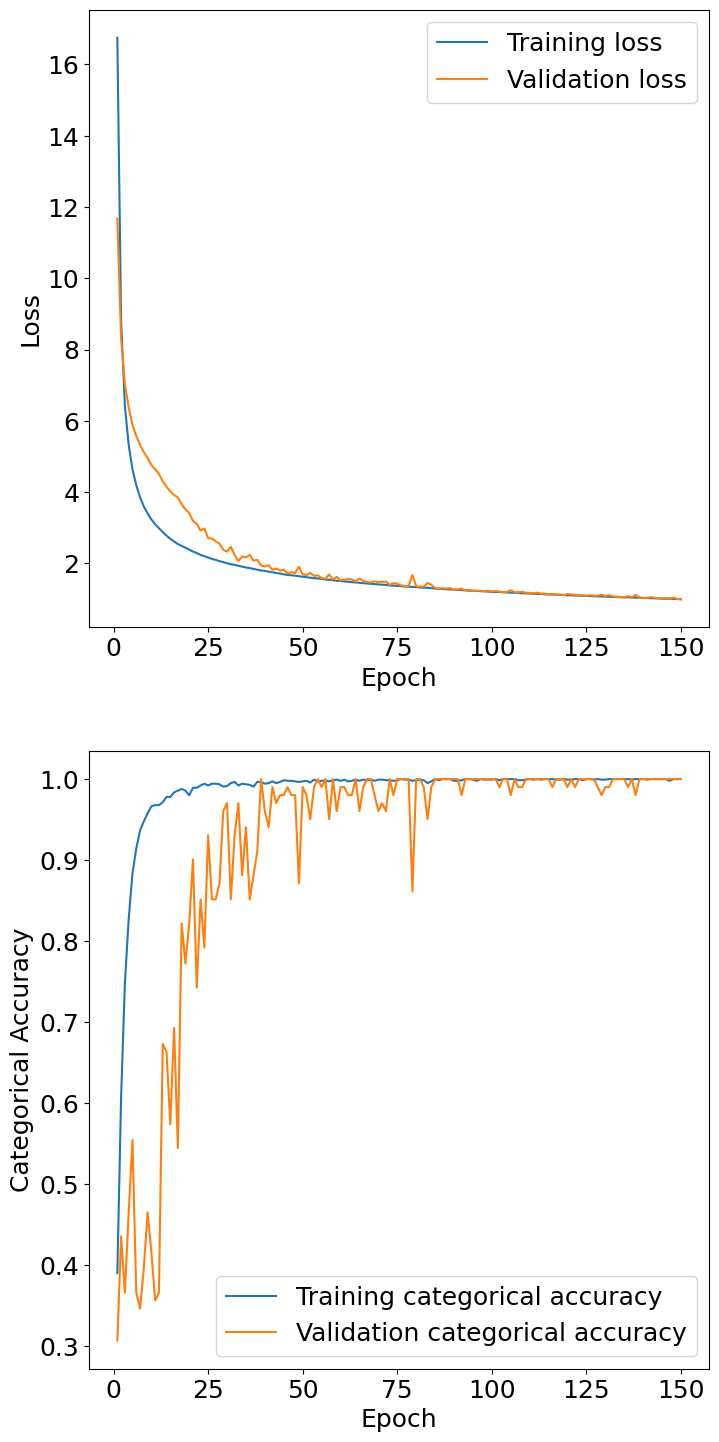

In [ ]:
x_points = np.arange(1,151)
y_points = np.array(history_LSTM["loss"])
plt.figux_points = np.arange(1,151)
y_points = np.array(history_LSTM["loss"])
plt.figure(figsize=(8, 18), dpi=100)
plt.subplot(2, 1, 1)
plt.plot(x_points, y_points)
y_points2 = np.array(history_LSTM["val_loss"])
plt.plot(x_points, y_points2)
plt.legend(["Training loss", "Validation loss"], loc ="upper right")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.subplot(2, 1, 2)
y_points = np.array(history_LSTM["categorical_accuracy"])
plt.plot(x_points, y_points)
y_points2 = np.array(history_LSTM["val_categorical_accuracy"])
plt.plot(x_points, y_points2)
plt.legend(["Training categorical accuracy", "Validation categorical accuracy"], loc ="lower right")
plt.xlabel("Epoch")
plt.ylabel("Categorical Accuracy")
plt.show()